Testing of CNN GAN architecture on anime character faces and actions

Epoch [100/1500], Batch [0/1], D Loss: 0.0013, G Loss: 11.4651
Epoch [200/1500], Batch [0/1], D Loss: 0.0606, G Loss: 14.0551
Epoch [300/1500], Batch [0/1], D Loss: 0.0117, G Loss: 11.8501
Epoch [400/1500], Batch [0/1], D Loss: 0.0077, G Loss: 14.3575
Epoch [500/1500], Batch [0/1], D Loss: 0.0179, G Loss: 14.6415
Epoch [600/1500], Batch [0/1], D Loss: 0.0664, G Loss: 12.1324
Epoch [700/1500], Batch [0/1], D Loss: 0.0489, G Loss: 10.0777
Epoch [800/1500], Batch [0/1], D Loss: 0.0079, G Loss: 13.1754
Epoch [900/1500], Batch [0/1], D Loss: 0.0031, G Loss: 17.5965
Epoch [1000/1500], Batch [0/1], D Loss: 0.0208, G Loss: 10.4450
Epoch [1100/1500], Batch [0/1], D Loss: 0.0676, G Loss: 12.4732
Epoch [1200/1500], Batch [0/1], D Loss: 0.0744, G Loss: 11.3217
Epoch [1300/1500], Batch [0/1], D Loss: 0.0424, G Loss: 8.1719
Epoch [1400/1500], Batch [0/1], D Loss: 0.1162, G Loss: 18.4242
Epoch [1500/1500], Batch [0/1], D Loss: 0.0099, G Loss: 8.8257


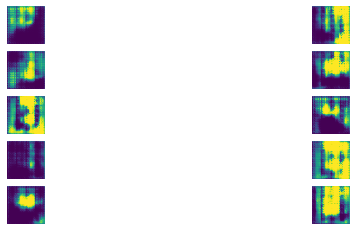

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.main = nn.Sequential(
            # upsample latent noise input
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),  # Output 3 channels for RGB images
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),  # input size: 3 channels, output size: 64 channels
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0)  # Output 1 channel for binary classification
        )
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation function

    def forward(self, x):
        x = self.main(x)
        return self.sigmoid(x)


# Hyperparameters
latent_dim = 128
batch_size = 64
lr = 0.001
lr2 = 0.002
epochs = 1500

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset_path = "D:/LargeStuff/jjk"
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

G = Generator(latent_dim)
D = Discriminator()

# loss function and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=lr)
optimizer_D = optim.Adam(D.parameters(), lr=lr2)

# Training loop
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(dataloader):
        batch_size = real_images.size(0)
        real_labels = torch.ones(batch_size, 1, 1, 1)
        fake_labels = torch.zeros(batch_size, 1, 1, 1)

        # Train Discriminator
        D.zero_grad()
        real_output = D(real_images)
        d_real_loss = criterion(real_output, real_labels)

        z = torch.randn(batch_size, latent_dim, 1, 1)
        fake_images = G(z)
        fake_output = D(fake_images.detach())
        d_fake_loss = criterion(fake_output, fake_labels)

        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        G.zero_grad()
        fake_output = D(fake_images)
        g_loss = criterion(fake_output, real_labels)
        g_loss.backward()
        optimizer_G.step()

        if (epoch+1) % 100 == 0 and i % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Batch [{i}/{len(dataloader)}], "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

def visualize_generated(G, num_images_per_class=2):
    with torch.no_grad():
        plt.figure(figsize=(10, 2 * num_images_per_class))
        for class_index in range(len(dataset.classes)):
            z = torch.randn(num_images_per_class, latent_dim, 1, 1)
            fake_images = G(z).detach().cpu()
            for i in range(num_images_per_class):
                plt.subplot(len(dataset.classes), num_images_per_class, class_index * num_images_per_class + i + 1)
                plt.imshow(fake_images[i][0].cpu())
                plt.axis('off')
        plt.show()

# Visualize generated images
visualize_generated(G)